In [24]:
import xml.dom.minidom

def sentenceToCoNLL(sentence):
    x = xml.dom.minidom.parse(sentence)
    nos = x.documentElement
    conll = []

    for no in nos.childNodes:
        if no.nodeType == x.TEXT_NODE:
            txt = str(no.nodeValue.strip())
            tokens = txt.split(" ")
            for token in tokens:
                tt = str(token+" O")
                conll.append(tt)
        if no.nodeType == x.ELEMENT_NODE:
            tag = str(no.getAttribute('CATEG'))
            tag = tag.strip()
            
            abbreviated_tag = getAbbreviatedTag(tag)
            
            eg = str(no.childNodes[0].nodeValue)
            eg = eg.strip()

            tokens_eg = eg.split(" ")
            if abbreviated_tag != "O":
                if len(tokens_eg) > 1:
                    for token_eg in tokens_eg:
                        if tokens_eg.index(token_eg) == 0:
                            tt = str(token_eg+" B-"+abbreviated_tag)
                            conll.append(tt)
                        else:
                            tt = str(token_eg+" I-"+abbreviated_tag)
                            conll.append(tt)
                else:
                    tt = str(tokens_eg[0]+" B-"+abbreviated_tag)
                    conll.append(tt)
            else:
                tt = str(tokens_eg[0]+" "+abbreviated_tag)
                conll.append(tt)
    return conll

In [25]:
def getAbbreviatedTag(tag):
    if tag == "EON" or tag == "eon":
        abbreviated_tag = "EON"
    elif tag == "ERA" or tag == "era":
        abbreviated_tag = "ERA"
    elif tag == "PERIODO" or tag == "periodo":
        abbreviated_tag = "PRD"
    elif tag == "EPOCA" or tag == "epoca":
        abbreviated_tag = "EPC"
    elif tag == "IDADE":
        abbreviated_tag = "IDA"
    elif tag == "sedimentaresSILICICLASTICAS":
        abbreviated_tag = "sedSLCT"
    elif tag == "sedimentaresCARBONATICAS":
        abbreviated_tag = "sedCARB"
    elif tag == "sedimentaresQUIMICAS":
        abbreviated_tag = "sedQUIM"
    elif tag == "sedimentaresORGANICAS":
        abbreviated_tag = "sedORGN"
    elif tag == "baciaSEDIMENTAR":
        abbreviated_tag = "bacSED"
    elif tag == "CONTEXTOgeologicoDeBACIA":
        abbreviated_tag = "ctxGBAC"
    elif tag == "unidadeESTRATIGRAFICA":
        abbreviated_tag = "uniESTG"
    elif tag == "outro":
        abbreviated_tag = "OTR"
    else:
        abbreviated_tag = "O"
    return abbreviated_tag

In [26]:
def sortedFiles(files):
    numeros, sorted_files = [], []
    for file in files:
        txt_num = file.replace("sentence_","")
        txt_num = txt_num.replace(".xml","")
        num = int(txt_num)
        numeros.append(num)
    sorted_num = sorted(numeros)
    
    for i in sorted_num:
        sorted_files.append("sentence_"+str(i)+".xml")
        
    return sorted_files

In [49]:
import os

def sentencesXMLToCoNLL(path):
    generalConll = []
    new_file = open("CoNLL-GeoCorpus.txt", "w+", encoding="utf8")
    files = os.listdir(path)
    sorted_files = sortedFiles(files)
    
    for sentence in sorted_files:
        conll = sentenceToCoNLL(path+"/"+sentence)
        for token in conll:
            new_file.write(token+"\n")
        new_file.write("\n")
        generalConll.append(conll)
    return generalConll
#generalConll = sentencesXMLToCoNLL("xml_corrigidos")

In [48]:
def getVerbose(path_out):
    all_tags, verboseList = [], []
    with open(path_out, "r", encoding="utf8") as file:
        for line in file:
            line = line.strip()
            token_tag = line.split(" ")
            tag = token_tag[-1]
            all_tags.append(tag)
    tag_set = sorted(set(all_tags))
    for t in tag_set:
        if t.find("I-") == -1 and t != "O":
            if tag_set.index(t) == 0:
                print("Sentences: "+str(all_tags.count(t)))
            else:
                print(t+": "+str(all_tags.count(t)))
                verboseList.append(t+"_"+str(all_tags.count(t)))
    return verboseList
#verboseList = getVerbose("CoNLL-GeoCorpus.txt")

In [47]:
import math
import random

def buildInformationDataset(generalConll, verboseList):
    counterB_EON = 0
    counterB_EPC = 0
    counterB_ERA = 0
    counterB_IDA = 0
    counterB_OTR = 0
    counterB_PRD = 0
    counterB_bacSED = 0
    counterB_ctxGBAC = 0
    counterB_sedCARB = 0
    counterB_sedORGN = 0
    counterB_sedQUIM = 0
    counterB_sedSLCT = 0
    counterB_uniESTG = 0
    datasetInformation = []
    trainSum, testSum, devSum = [], [], []
    print("-----ESPERADO-----")
    for category_numberGE in verboseList:
        flag = False
        category = category_numberGE.split("_")[0]
        numberGE = int(category_numberGE.split("_")[1])
        
        numberSentencesTest = math.ceil(0.2 * numberGE)
        numberSentencesTrain = numberGE - numberSentencesTest
        numberSentencesDev = math.ceil(0.05 * numberSentencesTrain)
        numberSentencesTrain = numberSentencesTrain - numberSentencesDev
        
        print("\033[1m"+category+":"+"\033[0;0m", numberGE)
        print("       Sentences Train: ", numberSentencesTrain)
        print("       Sentences Test: ", numberSentencesTest)
        print("       Sentences Dev: ", numberSentencesDev)
        print("       Sum: ", numberSentencesTrain+numberSentencesTest+numberSentencesDev)
        print("-----------------------------")
        
        trainSum.append(numberSentencesTrain)
        testSum.append(numberSentencesTest)
        devSum.append(numberSentencesDev)
        
        datasetInformation.append([category, numberGE, numberSentencesTrain, numberSentencesTest, numberSentencesDev])
    
    print("Number of EGs Train: ", sum(trainSum))
    print("Number of EGs Test: ", sum(testSum))
    print("Number of EGs Dev: ", sum(devSum))
    
    return sum(trainSum), sum(testSum), sum(devSum), datasetInformation

#sumTrain, sumTest, sumDev, datasetInformation = buildInformationDataset(generalConll, verboseList)

In [46]:
def splitData(generalConll, sumTrain, sumTest, sumDev, datasetInformation):
    counterB_EON = 0
    counterB_EPC = 0
    counterB_ERA = 0
    counterB_IDA = 0
    counterB_OTR = 0
    counterB_PRD = 0
    counterB_bacSED = 0
    counterB_ctxGBAC = 0
    counterB_sedCARB = 0
    counterB_sedORGN = 0
    counterB_sedQUIM = 0
    counterB_sedSLCT = 0
    counterB_uniESTG = 0
    counterTrain, counterTest, counterDev = 0, 0, 0
    listB_EON, listB_EPC, listB_ERA, listB_IDA, listB_OTR, listB_PRD = [], [], [], [], [], []
    listB_bacSED = []
    listB_ctxGBAC = []
    listB_sedCARB = []
    listB_sedORGN = []
    listB_sedQUIM = []
    listB_sedSLCT = []
    listB_uniESTG = []
    allEGs, diversas = [], []
    escolhidas = []
    
    print("-----ENCONTRADO-----")
    
    for sentence in generalConll:
        for token_tag in sentence:
            tag = token_tag.split(" ")[-1]
            if tag == "B-EON":
                counterB_EON+=1
                if sentence not in listB_EON and sentence not in escolhidas:
                    listB_EON.append(sentence)
                    escolhidas.append(sentence)
            elif tag == "B-ERA":
                counterB_ERA+=1
                if sentence not in listB_ERA and sentence not in escolhidas:
                    listB_ERA.append(sentence)
                    escolhidas.append(sentence)
            elif tag == "B-PRD":
                counterB_PRD+=1
                if sentence not in listB_PRD and sentence not in escolhidas:
                    listB_PRD.append(sentence)
                    escolhidas.append(sentence)
            elif tag == "B-EPC":
                counterB_EPC+=1
                if sentence not in listB_EPC and sentence not in escolhidas:
                    listB_EPC.append(sentence)
                    escolhidas.append(sentence)
            elif tag == "B-IDA":
                counterB_IDA+=1
                if sentence not in listB_IDA and sentence not in escolhidas:
                    listB_IDA.append(sentence)
                    escolhidas.append(sentence)
            elif tag == "B-OTR":
                counterB_OTR+=1
                if sentence not in listB_OTR and sentence not in escolhidas:
                    listB_OTR.append(sentence)
                    escolhidas.append(sentence)
            elif tag == "B-sedSLCT":
                counterB_sedSLCT+=1
                if sentence not in listB_sedSLCT and sentence not in escolhidas:
                    listB_sedSLCT.append(sentence)
                    escolhidas.append(sentence)
            elif tag == "B-sedCARB":
                counterB_sedCARB+=1
                if sentence not in listB_sedCARB and sentence not in escolhidas:
                    listB_sedCARB.append(sentence)
                    escolhidas.append(sentence)
            elif tag == "B-sedQUIM":
                counterB_sedQUIM+=1
                if sentence not in listB_sedQUIM and sentence not in escolhidas:
                    listB_sedQUIM.append(sentence)
                    escolhidas.append(sentence)
            elif tag == "B-sedORGN":
                counterB_sedORGN+=1
                if sentence not in listB_sedORGN and sentence not in escolhidas:
                    listB_sedORGN.append(sentence)
                    escolhidas.append(sentence)
            elif tag == "B-bacSED":
                counterB_bacSED+=1
                if sentence not in listB_bacSED and sentence not in escolhidas:
                    listB_bacSED.append(sentence)
                    escolhidas.append(sentence)
            elif tag == "B-ctxGBAC":
                counterB_ctxGBAC+=1
                if sentence not in listB_ctxGBAC and sentence not in escolhidas:
                    listB_ctxGBAC.append(sentence)
                    escolhidas.append(sentence)
            elif tag == "B-uniESTG":
                counterB_uniESTG+=1
                if sentence not in listB_uniESTG and sentence not in escolhidas:
                    listB_uniESTG.append(sentence)
                    escolhidas.append(sentence)
    flag = False
    allListEGs = [listB_EON, listB_EPC, listB_ERA, listB_IDA, listB_OTR, listB_PRD, listB_bacSED, listB_ctxGBAC, listB_sedCARB, listB_sedORGN, listB_sedQUIM, listB_sedSLCT, listB_uniESTG]
    
    for sentenceList in allListEGs:
        for sentence in sentenceList:
            allEGs.append(sentence)
    
    for s in generalConll:
        if s not in allEGs:
            diversas.append(s)
            
    soma = len(listB_EON)+len(listB_EPC)+len(listB_ERA)+len(listB_IDA)+len(listB_OTR)+len(listB_PRD)+len(listB_bacSED)+len(listB_ctxGBAC)+len(listB_sedCARB)+len(listB_sedORGN)+len(listB_sedQUIM)+len(listB_sedSLCT)+len(listB_uniESTG)
    
    print("B-EON:", len(listB_EON))
    print("B-EPC:", len(listB_EPC))
    print("B-ERA:", len(listB_ERA))
    print("B-IDA:", len(listB_IDA))
    print("B-OTR:", len(listB_OTR))
    print("B-PRD:", len(listB_PRD))
    print("B-bacSED:", len(listB_bacSED))
    print("B-ctxGBAC:", len(listB_ctxGBAC))
    print("B-sedCARB:", len(listB_sedCARB))
    print("B-sedORGN:", len(listB_sedORGN))
    print("B-sedQUIM:", len(listB_sedQUIM))
    print("B-sedSLCT:", len(listB_sedSLCT))
    print("B-uniESTG:", len(listB_uniESTG))
    print("Soma EGs:", soma)
    print("----------------------------")
    print("Diversas:", len(diversas))
    print("Total:", soma + len(diversas))
    
    return listB_EON, listB_EPC, listB_ERA, listB_IDA, listB_OTR, listB_PRD, listB_bacSED, listB_ctxGBAC, listB_sedCARB, listB_sedORGN, listB_sedQUIM, listB_sedSLCT, listB_uniESTG, diversas

#listB_EON, listB_EPC, listB_ERA, listB_IDA, listB_OTR, listB_PRD, listB_bacSED, listB_ctxGBAC, listB_sedCARB, listB_sedORGN, listB_sedQUIM, listB_sedSLCT, listB_uniESTG, diversas = splitData(generalConll, sumTrain, sumTest, sumDev, datasetInformation)

In [45]:
import random

def createTrainTestDev(listB_EON, listB_EPC, listB_ERA, listB_IDA, listB_OTR, listB_PRD, listB_bacSED, listB_ctxGBAC, listB_sedCARB, listB_sedORGN, listB_sedQUIM, listB_sedSLCT, listB_uniESTG, diversas, generalConll):
    counter = 0
    allListEGs = [listB_EON, listB_EPC, listB_ERA, listB_IDA, listB_OTR, listB_PRD, listB_bacSED, listB_ctxGBAC, listB_sedCARB, listB_sedORGN, listB_sedQUIM, listB_sedSLCT, listB_uniESTG, diversas]
    sentencesToTrain, sentencesToTest, sentencesToDev = [], [], []
    for listEG in allListEGs:
        qtd = math.ceil(0.2 * len(listEG))
        print(allListEGs.index(listEG), qtd)
        while counter <= qtd:
            sorteada = random.choice(listEG)
            if sorteada not in sentencesToTest:
                sentencesToTest.append(sorteada)
                counter+=1
        counter=0
        
    counter = 0
    for listEG in allListEGs:
        qtd = math.ceil(0.05 * len(listEG))
        print(allListEGs.index(listEG), qtd)
        while counter <= qtd:
            sorteada = random.choice(listEG)
            if sorteada not in sentencesToTest and sorteada not in sentencesToDev:
                sentencesToDev.append(sorteada)
                counter+=1
        counter=0
                
    for sentence in generalConll:
        if sentence not in sentencesToTest and sentence not in sentencesToDev:
            if sentence not in sentencesToTrain:
                sentencesToTrain.append(sentence)
    
    for i in range(10):
        random.shuffle(sentencesToTrain)
        random.shuffle(sentencesToTest)
        random.shuffle(sentencesToDev)
    
    print(print("-----FINAL-----"))
    print("Train:", len(sentencesToTrain))
    print("Test:", len(sentencesToTest))
    print("Dev:", len(sentencesToDev))
    print("Total:", len(sentencesToTrain)+len(sentencesToTest)+len(sentencesToDev))
    
    return sentencesToTrain, sentencesToTest, sentencesToDev

#sentencesToTrain, sentencesToTest, sentencesToDev = createTrainTestDev(listB_EON, listB_EPC, listB_ERA, listB_IDA, listB_OTR, listB_PRD, listB_bacSED, listB_ctxGBAC, listB_sedCARB, listB_sedORGN, listB_sedQUIM, listB_sedSLCT, listB_uniESTG, diversas, generalConll)

In [39]:
def exportToText(fileName, sentences):
    new_file = open(fileName, "w+", encoding="utf8")
    
    for sentence in sentences:
        for line in sentence:
            new_file.write(line+"\n")
        new_file.write("\n")
    new_file.close()
    print("Created Corpus: ", fileName)

In [40]:
def main():
    generalConll = sentencesXMLToCoNLL("xml_corrigidos")
    verboseList = getVerbose("CoNLL-GeoCorpus.txt")
    sumTrain, sumTest, sumDev, datasetInformation = buildInformationDataset(generalConll, verboseList)
    listB_EON, listB_EPC, listB_ERA, listB_IDA, listB_OTR, listB_PRD, listB_bacSED, listB_ctxGBAC, listB_sedCARB, listB_sedORGN, listB_sedQUIM, listB_sedSLCT, listB_uniESTG, diversas = splitData(generalConll, sumTrain, sumTest, sumDev, datasetInformation)
    sentencesToTrain, sentencesToTest, sentencesToDev = createTrainTestDev(listB_EON, listB_EPC, listB_ERA, listB_IDA, listB_OTR, listB_PRD, listB_bacSED, listB_ctxGBAC, listB_sedCARB, listB_sedORGN, listB_sedQUIM, listB_sedSLCT, listB_uniESTG, diversas, generalConll)
    exportToText("GeoCorpusDistribuido/Train-CoNLL-GeoCorpus.txt", sentencesToTrain)
    exportToText("GeoCorpusDistribuido/Test-CoNLL-GeoCorpus.txt", sentencesToTest)
    exportToText("GeoCorpusDistribuido/Dev-CoNLL-GeoCorpus.txt", sentencesToDev)

In [41]:
if __name__ == "__main__":
    main()

Sentences: 6215
B-EON: 288
B-EPC: 650
B-ERA: 333
B-IDA: 798
B-OTR: 739
B-PRD: 637
B-bacSED: 245
B-ctxGBAC: 262
B-sedCARB: 241
B-sedORGN: 22
B-sedQUIM: 5
B-sedSLCT: 743
B-uniESTG: 581
-----ESPERADO-----
B-EON: 288
       Sentences Train:  218
       Sentences Test:  58
       Sentences Dev:  12
       Sum:  288
-----------------------------
B-EPC: 650
       Sentences Train:  494
       Sentences Test:  130
       Sentences Dev:  26
       Sum:  650
-----------------------------
B-ERA: 333
       Sentences Train:  252
       Sentences Test:  67
       Sentences Dev:  14
       Sum:  333
-----------------------------
B-IDA: 798
       Sentences Train:  606
       Sentences Test:  160
       Sentences Dev:  32
       Sum:  798
-----------------------------
B-OTR: 739
       Sentences Train:  561
       Sentences Test:  148
       Sentences Dev:  30
       Sum:  739
-----------------------------
B-PRD: 637
       Sentences Train:  483
       Sentences Test:  128
       Sentences Dev:  26
 

## Chart Dataset

In [72]:
def loadData(filename):
    sentences, aux = [], []
    with open(filename, "r", encoding="utf8") as file:
        for line in file:
            if line != "\n":
                line = line.strip()
                aux.append(line)
            else:
                sentences.append(aux)
                aux = []
    return sentences

train = loadData("GeoCorpusDistribuido/Train-CoNLL-GeoCorpus.txt")
test = loadData("GeoCorpusDistribuido/Test-CoNLL-GeoCorpus.txt")
dev = loadData("GeoCorpusDistribuido/Dev-CoNLL-GeoCorpus.txt")

In [73]:
import pandas as pd

def dataInformationToChart(sentences):
    tagCounter=0
    x, y = [], []
    allBTags, tagList = [], []
    for sentence in sentences:
        for line in sentence:
            tag = line.split(" ")[-1]
            if tag.find("I-") == -1 and tag != "O":
                if tag not in tagList:
                    tagList.append(tag)
    #print("Total de EGs: ", len(tagList))
    for tagB in tagList:
        for sentence in sentences:
            for line in sentence:
                tag = line.split(" ")[-1]
                if tagB == tag:
                    tagCounter+=1
        x.append(tagB)
        y.append(tagCounter)
        tagCounter=0
    #dataF = {'manufacturer': x, 'cty': y}
    dataF = {'categorias': x, 'qtd': y}
    df = pd.DataFrame(data=dataF)
    return df
        
df_train = dataInformationToChart(train)
df_test = dataInformationToChart(test)
df_dev = dataInformationToChart(dev)

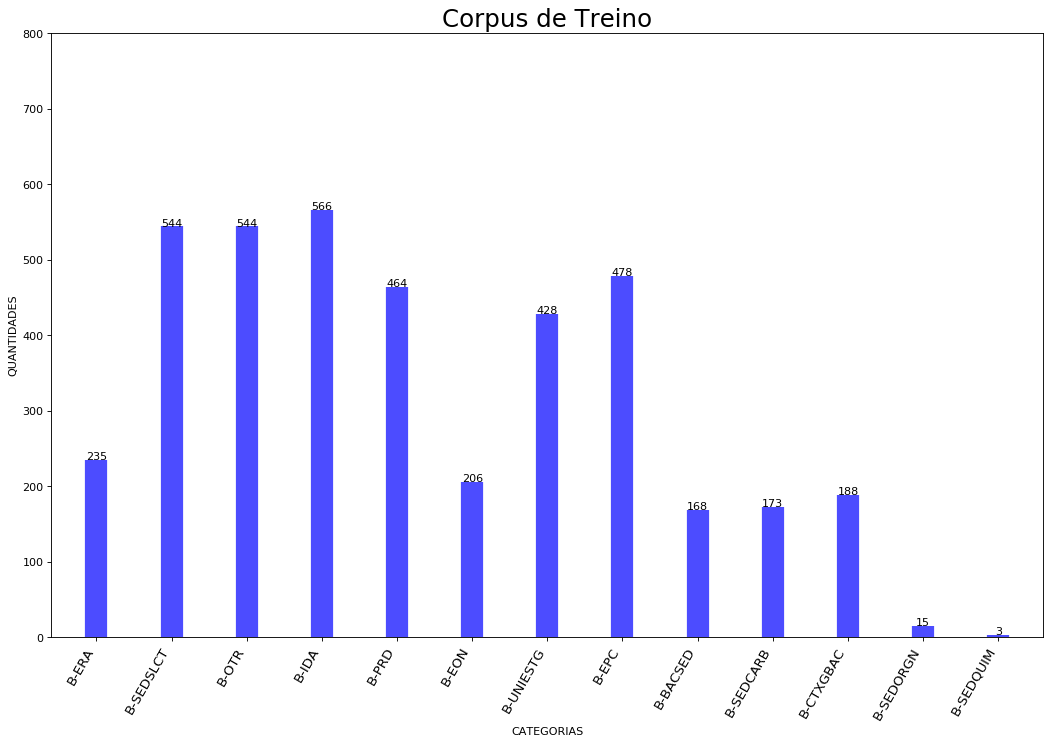

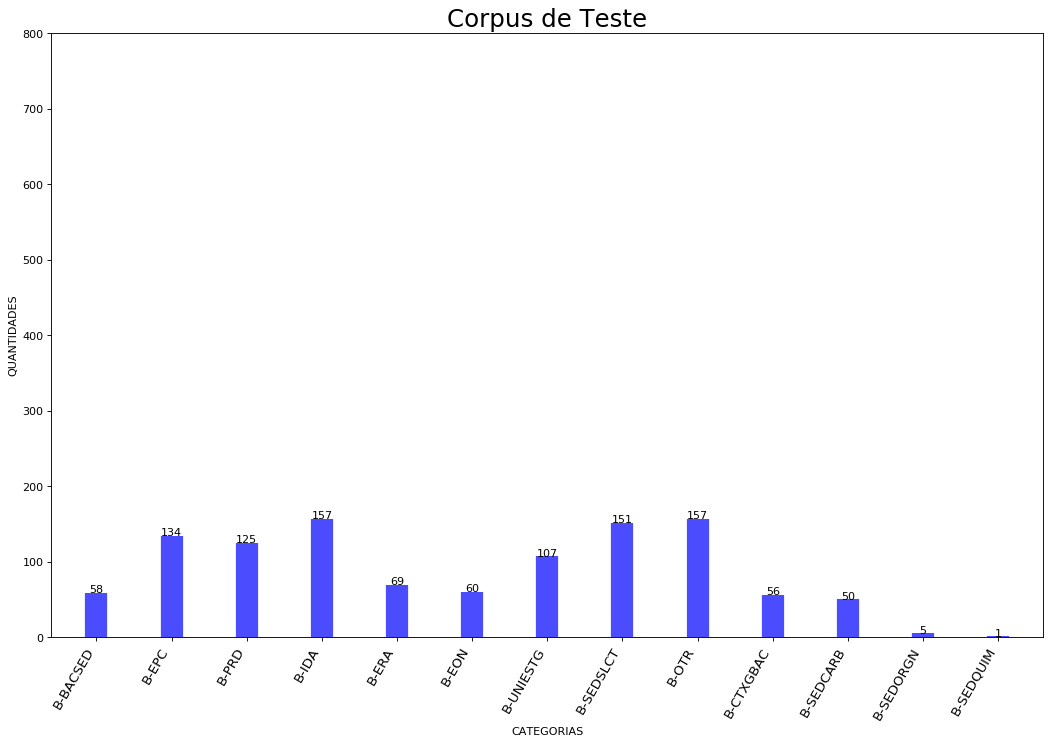

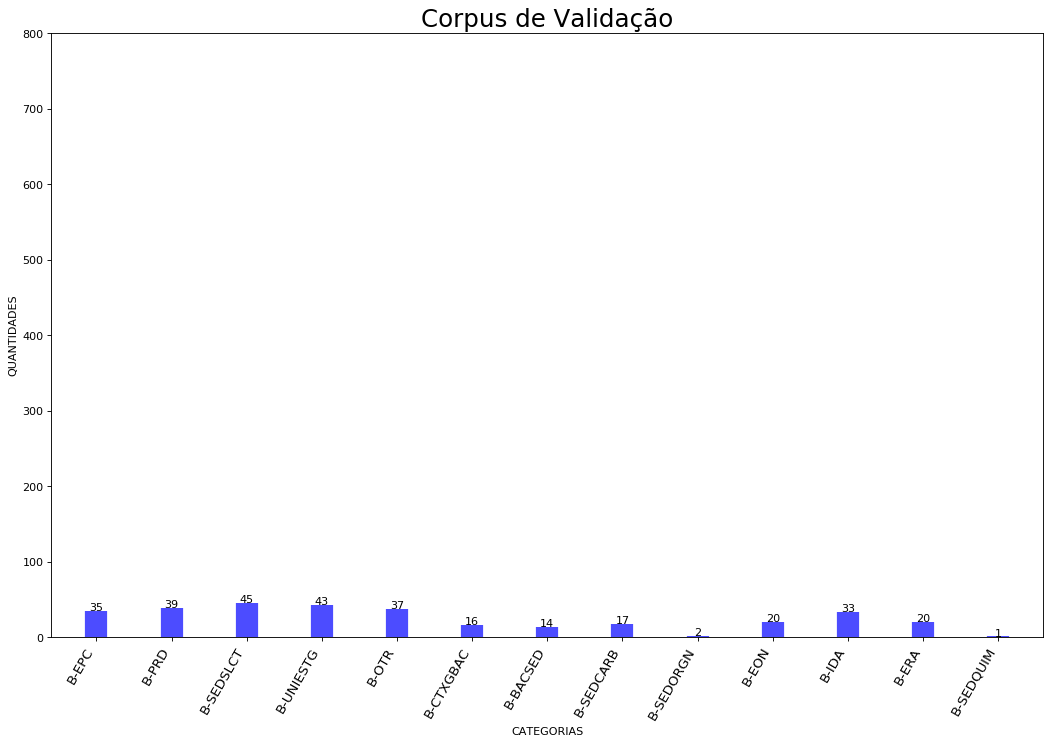

In [74]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plotChartCorpus(df, chartName):
    fig, ax = plt.subplots(figsize=(16,10), facecolor='white', dpi= 80)
    ax.vlines(x=df.index, ymin=0, ymax=df.qtd, color='blue', alpha=0.7, linewidth=20)

    for i, qtd in enumerate(df.qtd):
        ax.text(i, qtd+0.5, round(qtd, 1), horizontalalignment='center')

    ax.set_title(chartName, fontdict={'size':22})
    ax.set(ylabel='QUANTIDADES', ylim=(0, 800))
    ax.set(xlabel='CATEGORIAS')
    plt.xticks(df.index, df.categorias.str.upper(), rotation=60, horizontalalignment='right', fontsize=12)

    plt.show()
    
plotChartCorpus(df_train, "Corpus de Treino")
plotChartCorpus(df_test, "Corpus de Teste")
plotChartCorpus(df_dev, "Corpus de Validação")